# Data Analysis Notebook

## What is this?

This notebook contains all code that is used to analysis the data for the paper "Faster, More Accurate Results, and Better Grades: The Effect of a Local LLM in an Introductory Programming Exam".

## How to use it?

If you want to reproduce the results and figures reported in the paper, execute each code cell in consecutive order. In particular, the code cells in section "Data Cleansing" have to be executed _before_ the remaining code cells!

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import mannwhitneyu, spearmanr, anderson

In [215]:
df = pd.read_csv("data.csv", delimiter=";")

In [216]:
df["Unit Test"].describe()

count     48.000000
mean      80.979167
std       24.523102
min       12.000000
25%       73.750000
50%       90.000000
75%      100.000000
max      100.000000
Name: Unit Test, dtype: float64

## Data Cleansing

The columns `Task x`, contain the time (in seconds) it takes an experiment subject to solve the respective task `x`. In case two space separated integer values are recorded in this column, the first one denotes the time in seconds and the second records the number of prompts that were used.

Since this is a dense notation, we split them into separate columns to facilitate later analysis.

In [3]:
# Generate a separate CSV file only for the demographics data
demographics_questions = [
    "In what subject was your bachelor?", 
    "How many years of developer experience do you have?",
    "How many months is it since you coded in Java?", 
    "How many years of experience do you have with Visual Studio Code?",
    "How much experience in years do you have in using an LLM(ChatGPT, CoPilot, Gemini)?",
    "Which operating system do you usually use"
]
df[["Participant", ] + demographics_questions].dropna().to_csv("demographics.csv", index=False)

In [217]:
%%bash
# Generate a separate CSV file only for the numerical data
python datacleansing.py
# After this step, a file dataclean.csv is available

## Demographics

In [5]:
demo_df = pd.read_csv("demographics.csv")
demo_df

,Participant,In what subject was your bachelor?,How many years of developer experience do you have?,How many months is it since you coded in Java?,How many years of experience do you have with Visual Studio Code?,"How much experience in years do you have in using an LLM(ChatGPT, CoPilot, Gemini)?",Which operating system do you usually use
0,1,Business Economics & Information System,4.0,0.0,2.0,2.0,MacOS
1,2,International sales and marketing,2.0,0.0,2.0,0.5,Windows
2,3,Innovation and Entrepreneurship,1.0,0.0,1.0,1.0,MacOS
3,4,Visual Design (Game and Interaction Design),4.0,2.0,2.0,0.0,Windows
4,5,Communication & IT,2.0,3.0,2.0,1.0,MacOS
5,6,Physiotherapy,2.0,3.0,2.0,1.5,MacOS
6,7,Global Business Informatics,2.0,9.0,2.0,1.0,Windows
7,8,Literaturvidenskab,2.0,12.0,2.5,1.5,MacOS
8,9,Global Business Informatics,2.0,13.0,2.0,1.0,MacOS
9,10,Economy,1.5,8.0,1.5,0.5,MacOS


In [6]:
sector_mapping = {
    "Business Economics & Information System": "business and economics",
    "International sales and marketing": "business and economics",
    "Innovation and Entrepreneurship": "business and economics",
    "Visual Design (Game and Interaction Design)": "communications and media",
    "Communication & IT": "IT and technology",
    "Physiotherapy": "health and medicine",
    "Global Business Informatics": "IT and technology" ,
    "Literaturvidenskab": "communications and media",
    "Global Business Informatics": "IT and technology",
    "Economy": "business and economics",
    "Modern India and South Asia Studies": "social sciences",
    "Digital Design and Interactive Technologies": "communications and media",
    "Sound Design": "IT and technology",
    "Bachelor of education": "education",
    "Energy Engineering": "IT and technology",
    "Business economics & IT": "business and economics",
    "Business": "business and economics",
    "Gastronomy (Food Science and Agriculture)": "gastronomy",
    "International Business in Asia": "business and economics",
    "IT & Communication": "communications and media",
    "Radiograph": "health and medicine",
    "Software Design": "IT and technology",
    "Communication": "communications and media",
    "International Business": "business and economics",
}
demo_df["sector"] = demo_df["In what subject was your bachelor?"].apply(lambda el: sector_mapping[el.strip()])

In [7]:
demo_df.groupby("sector")["Participant"].count()

sector
IT and technology           6
business and economics      8
communications and media    5
education                   1
gastronomy                  1
health and medicine         2
social sciences             1
Name: Participant, dtype: int64

In [8]:
demo_df["How many years of developer experience do you have?"].describe()

count    24.000000
mean      1.937500
std       0.981486
min       0.000000
25%       1.500000
50%       2.000000
75%       2.000000
max       4.000000
Name: How many years of developer experience do you have?, dtype: float64

In [9]:
demo_df["How many months is it since you coded in Java?"].describe()

count    24.000000
mean      4.833333
std       4.429807
min       0.000000
25%       0.750000
50%       3.000000
75%       8.000000
max      13.000000
Name: How many months is it since you coded in Java?, dtype: float64

In [10]:
demo_df["How many years of experience do you have with Visual Studio Code?"].describe()

count    24.000000
mean      2.145833
std       0.994323
min       1.000000
25%       1.500000
50%       2.000000
75%       2.125000
max       6.000000
Name: How many years of experience do you have with Visual Studio Code?, dtype: float64

In [11]:
demo_df["How much experience in years do you have in using an LLM(ChatGPT, CoPilot, Gemini)?"].describe()

count    24.000000
mean      1.000000
std       0.390095
min       0.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       2.000000
Name: How much experience in years do you have in using an LLM(ChatGPT, CoPilot, Gemini)?, dtype: float64

## Results

In [348]:
df = pd.read_csv("dataclean.csv")
df.time = pd.to_timedelta(df.time, unit="s")

###  RQ1: How does a local LLM affect students’ task completion time in an IP exam?

In [349]:
mask = (df.llm_support == True)
df.loc[mask, "treatment"] = "with"
mask = (df.llm_support == False)
df.loc[mask, "treatment"] = "without"

[[<matplotlib.axis.YTick at 0x7fdd4357ed30>,

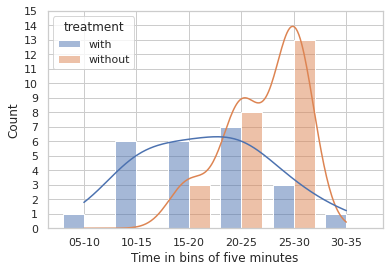

In [397]:
df_times = df.groupby(["treatment", "experiment_subject"])["time"].sum().reset_index()
df_times["time_in_5min_bins"] = df_times.time.dt.seconds // 60 // 5 * 5
df_times["bin_labels"] = df_times.time_in_5min_bins.apply(lambda el: f"{el:02d}-{el+5}") 

df_times.sort_values(by="bin_labels", inplace=True)
p = sns.histplot(data=df_times, x="bin_labels", hue="treatment", multiple="dodge", 
                 binwidth=5, kde=True,  shrink=.8)
p.set(xlabel="Time in bins of five minutes")
p.set(yticks=(range(df_times.groupby("time_in_5min_bins").bin_labels.count().max())))

In [92]:
df_time_with_treatment = df[df.llm_support == True].groupby("experiment_subject")["time"].sum().reset_index()
df_time_with_treatment.drop(columns=["experiment_subject"], inplace=True)
# Divisions and multiplications are to convert number of seconds in five minute bins for counting
df_time_with_treatment.time  = df_time_with_treatment.time.dt.seconds // 60 // 5 * 5
df_time_with_treatment.rename(columns={"time": "with treatment"}, inplace=True)
df_time_wo_treatment = df[df.llm_support == False].groupby("experiment_subject")["time"].sum().reset_index()
df_time_wo_treatment.drop(columns=["experiment_subject"], inplace=True)
df_time_wo_treatment.time = df_time_wo_treatment.time.dt.seconds // 60 // 5 * 5
df_time_wo_treatment.rename(columns={"time": "without treatment"}, inplace=True)
df_times = pd.merge(df_time_with_treatment, df_time_wo_treatment, left_index=True, right_index=True)

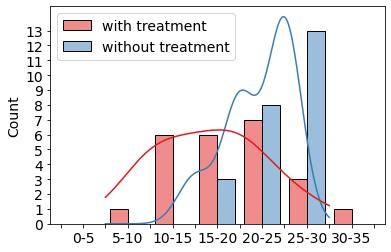

In [148]:
p = sns.histplot(df_times, multiple="dodge", kde=True, 
                 binrange=(0, 35), binwidth=5, shrink=.8)

xrange = np.arange(0, 36, 2.5)
labels = ["" for _ in range(len(xrange))]
for idx in range(1, 14, 2):
    labels[idx] = f"{int(xrange[idx-1])}-{int(xrange[idx+1])}"
p.set_xticks(xrange, labels=labels) 
p.set_yticks(range(max((df_times["with treatment"].value_counts().max(), 
                        df_times["without treatment"].value_counts().max())) + 1)) 
plt.savefig("images/time_comparison.pdf", bbox_inches="tight")

[Text(0, 0.5, 'Time in minutes')]

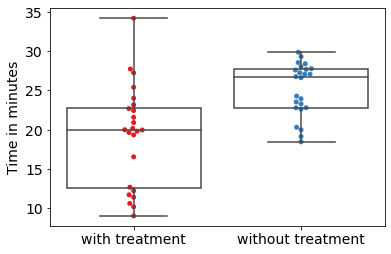

In [236]:
df_time_with_treatment = df[df.llm_support == True].groupby("experiment_subject")["time"].sum().reset_index()
df_time_with_treatment.drop(columns=["experiment_subject"], inplace=True)
df_time_with_treatment["treatment"] = "with treatment"
df_time_wo_treatment = df[df.llm_support == False].groupby("experiment_subject")["time"].sum().reset_index()
df_time_wo_treatment.drop(columns=["experiment_subject"], inplace=True)
df_time_wo_treatment["treatment"] = "without treatment"

df_times = pd.concat((df_time_with_treatment, df_time_wo_treatment), axis=0, ignore_index=True)
df_times.time = df_times.time.dt.total_seconds() / 60

p1 = sns.boxplot(data=df_times, x="treatment", y="time", boxprops={"facecolor": "None"})
p2 = sns.swarmplot(data=df_times, x="treatment", y="time", zorder=.5)
p1.set(xlabel=None)
p1.set(ylabel="Time in minutes")

[Text(0, 0.5, 'Time in minutes')]

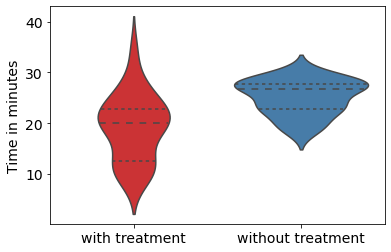

In [281]:
p1 = sns.violinplot(data=df_times, x="treatment", y="time", inner="quart", boxprops={"facecolor": "None"})
p2 = sns.swarmplot(data=df_times, x="treatment", y="time", zorder=.5)
p1.set(xlabel=None)
p1.set(ylabel="Time in minutes")

In [179]:
df_time_with_treatment = df[df.llm_support == True].groupby("experiment_subject")["time"].sum().reset_index()
df_time_with_treatment.drop(columns=["experiment_subject"], inplace=True)
df_time_with_treatment.rename(columns={"time": "with treatment"}, inplace=True)
df_time_wo_treatment = df[df.llm_support == False].groupby("experiment_subject")["time"].sum().reset_index()
df_time_wo_treatment.drop(columns=["experiment_subject"], inplace=True)
df_time_wo_treatment.rename(columns={"time": "without treatment"}, inplace=True)
df_times = pd.merge(df_time_with_treatment, df_time_wo_treatment, left_index=True, right_index=True)
df_times.describe()

,with treatment,without treatment
count,24,24
mean,0 days 00:19:15.625000,0 days 00:25:08.083333333
std,0 days 00:06:26.521703367,0 days 00:03:23.501931764
min,0 days 00:08:58,0 days 00:18:26
25%,0 days 00:12:31.250000,0 days 00:22:47.750000
50%,0 days 00:19:58,0 days 00:26:42
75%,0 days 00:22:48.250000,0 days 00:27:43.250000
max,0 days 00:34:14,0 days 00:29:53


Test if data is normally distributed. Visual inspection of the histogram above suggests that the collected time data from the "with treatment" group is normally distributed, whereas the data from the "without treatment" group does not.

To test if the data is normally distributed, we conduct an Anderson-Darling test, which tests the _"null hypothesis that a random sample was drawn from a normal distribution (with unspecified mean and standard deviation)"_, see [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html).

Since the value of the statistic is smaller than the critical value at a significance level of 5%, we cannot reject the null hypothesis for the "with treatment" group.

In [184]:
anderson(df_times["with treatment"])

AndersonResult(statistic=0.5434872299135982, critical_values=array([0.513, 0.584, 0.701, 0.817, 0.972]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

However, for the "without treatment" group, the value of the statistic exceeds the critical value at a significance level of 5%, therefore we reject the null hypothesis here.

In [185]:
anderson(df_times["without treatment"])

AndersonResult(statistic=0.803778836614363, critical_values=array([0.513, 0.584, 0.701, 0.817, 0.972]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

Since the data for the "without treatment" group is not uniformly distributed, we cannot apply a Student's T-test to assess the means of the two groups. But we can apply a Mann-Whitney-U test to test if the median of the two groups differ significantly. 

Null hypothesis $H_0$: the distributions of both populations are identical.
The alternative hypothesis $H_1$ is that the distributions are not identical.
Since the value of the statistic below is large and since the p-value is smaller than 0.05, we reject the null hypothesis, i.e., the distributions of both populations is different and the difference in the median listed below is statistically significant.

In [17]:
mannwhitneyu(df_times["with treatment"], df_times["without treatment"])

MannwhitneyuResult(statistic=116.0, pvalue=0.0004056716724965548)

In [187]:
df_times[["without treatment", "with treatment"]].describe()

,without treatment,with treatment
count,24,24
mean,0 days 00:25:08.083333333,0 days 00:19:15.625000
std,0 days 00:03:23.501931764,0 days 00:06:26.521703367
min,0 days 00:18:26,0 days 00:08:58
25%,0 days 00:22:47.750000,0 days 00:12:31.250000
50%,0 days 00:26:42,0 days 00:19:58
75%,0 days 00:27:43.250000,0 days 00:22:48.250000
max,0 days 00:29:53,0 days 00:34:14


In [186]:
def compute_improvement_pct(df, where="median"):
    """ Computes the percent-wise increase or decrease from withtout treatment to
    with treatment, per default for the mean.
    
    Alternative values for where are "mean", "min", "max", "q1", "q2"
    """
    if where == "median":
        where = "50%"
    elif where == "q1":
        where = "25%"
    elif where == "q3":
        where = "75%"
    # requires that input dataframe has without and with treatment columns
    col_order = ["without treatment", "with treatment"]
    change_ratio = df[col_order].describe().loc[where].pct_change()["with treatment"]
    growth = "increase" if change_ratio >= 0 else "decrease"
    change_in_pct = round(abs(change_ratio) * 100, 2)
    return growth, col_order, change_in_pct

compute_improvement_pct(df_times)

('decrease', ['without treatment', 'with treatment'], 25.22)

###  RQ2: How does a local LLM affect correctness of students’ source code in an IP exam?

**TODO**: Run again with fixed and updated imput data

In [220]:
df_test_ratios_with_treatment = df[df.llm_support == True].groupby("experiment_subject")["test_ratio"].first().reset_index()
df_test_ratios_wo_treatment = df[df.llm_support == False].groupby("experiment_subject")["test_ratio"].first().reset_index()
df_test_ratios = pd.merge(df_test_ratios_with_treatment, df_test_ratios_wo_treatment, on="experiment_subject")
df_test_ratios.rename(columns={"test_ratio_x": "with treatment", "test_ratio_y": "without treatment"}, inplace=True)
df_test_ratios.drop(columns=["experiment_subject"], inplace=True)

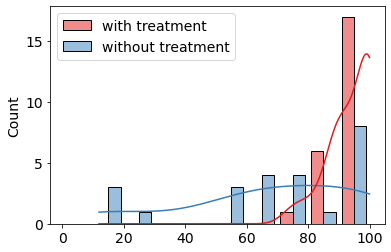

In [221]:
sns.histplot(df_test_ratios, multiple="dodge", kde=True, 
             binrange=(0, 100), binwidth=10, shrink=.8)
plt.savefig("images/test_ratio_comparison.pdf", bbox_inches="tight")

[Text(0, 0.5, 'Test ratio in %')]

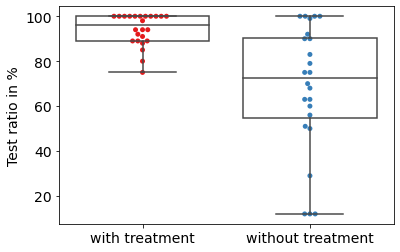

In [234]:
df_test_ratios_with_treatment = df[df.llm_support == True].groupby("experiment_subject")["test_ratio"].first().reset_index()
df_test_ratios_with_treatment["treatment"] = "with treatment"
df_test_ratios_wo_treatment = df[df.llm_support == False].groupby("experiment_subject")["test_ratio"].first().reset_index()
df_test_ratios_wo_treatment["treatment"] = "without treatment"
df_test_ratios = pd.concat((df_test_ratios_with_treatment, df_test_ratios_wo_treatment), axis=0, ignore_index=True)

p1 = sns.boxplot(data=df_test_ratios, x="treatment", y="test_ratio", boxprops={"facecolor": "None"})
p2 = sns.swarmplot(data=df_test_ratios, x="treatment", y="test_ratio", zorder=.5)
p1.set(xlabel=None)
p1.set(ylabel="Test ratio in %")

<AxesSubplot:xlabel='treatment', ylabel='test_ratio'>

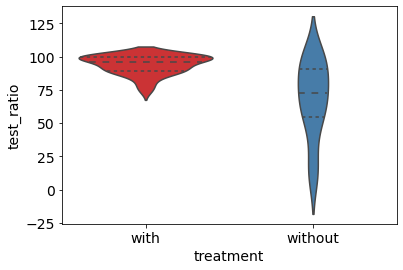

In [226]:
sns.violinplot(data=df_test_ratios, x="treatment", y="test_ratio", inner="quart")

In [239]:
df_test_ratios_with_treatment = df[df.llm_support == True].groupby("experiment_subject")["test_ratio"].first().reset_index()
df_test_ratios_wo_treatment = df[df.llm_support == False].groupby("experiment_subject")["test_ratio"].first().reset_index()
df_test_ratios = pd.merge(df_test_ratios_with_treatment, df_test_ratios_wo_treatment, on="experiment_subject")
df_test_ratios.rename(columns={"test_ratio_x": "with treatment", "test_ratio_y": "without treatment"}, inplace=True)
df_test_ratios.drop(columns=["experiment_subject"], inplace=True)
df_test_ratios.describe()

,with treatment,without treatment
count,24.000000,24.000000
mean,94.083333,67.875000
std,7.143965,28.627005
min,75.000000,12.000000
25%,89.000000,54.750000
50%,96.000000,72.500000
75%,100.000000,90.500000
max,100.000000,100.000000


In [242]:
anderson(df_test_ratios["with treatment"])

AndersonResult(statistic=1.6231796884959273, critical_values=array([0.513, 0.584, 0.701, 0.817, 0.972]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [243]:
anderson(df_test_ratios["without treatment"])

AndersonResult(statistic=0.7631029260096156, critical_values=array([0.513, 0.584, 0.701, 0.817, 0.972]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [240]:
mannwhitneyu(df_test_ratios["with treatment"], df_test_ratios["without treatment"])

MannwhitneyuResult(statistic=462.5, pvalue=0.00026680993018062443)

In [241]:
compute_improvement_pct(df_test_ratios)

('increase', ['without treatment', 'with treatment'], 32.41)

### RQ3: How does a local LLM affect students’ grades in an IP exam?

In [25]:
df_points_with_treatment = df[df.llm_support == True].groupby("experiment_subject")["points"].sum().reset_index()
df_points_wo_treatment = df[df.llm_support == False].groupby("experiment_subject")["points"].sum().reset_index()
df_points = pd.merge(df_points_with_treatment, df_points_wo_treatment, on="experiment_subject", how="outer")
df_points.rename(columns={"points_x": "with treatment", "points_y": "without treatment"}, inplace=True)
df_points.drop(columns=["experiment_subject"], inplace=True)

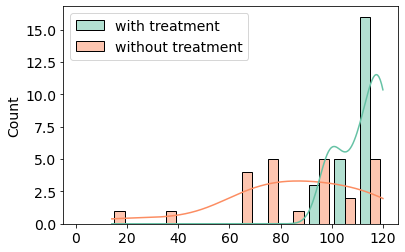

In [27]:
min_points, max_points, binwidth = 0, 120, 10
sns.histplot(df_points, color='blue', multiple="dodge", kde=True, 
             binrange=(min_points, max_points), binwidth=binwidth,
             shrink=.8)
plt.savefig("images/point_comparison.pdf", bbox_inches="tight")

[Text(0, 0.5, 'Number of points')]

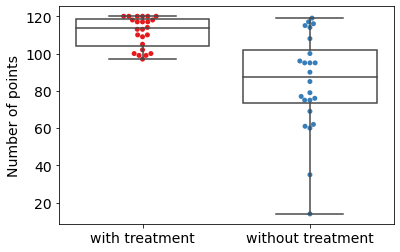

In [290]:
df_points_with_treatment = df[df.llm_support == True].groupby("experiment_subject")["points"].sum().reset_index()
df_points_with_treatment["treatment"] = "with treatment"
df_points_wo_treatment = df[df.llm_support == False].groupby("experiment_subject")["points"].sum().reset_index()
df_points_wo_treatment["treatment"] = "without treatment"

df_points = pd.concat((df_points_with_treatment, df_points_wo_treatment), axis=0, ignore_index=True)
df_points.drop(columns=["experiment_subject"], inplace=True)

p1 = sns.boxplot(data=df_points, x="treatment", y="points", boxprops={"facecolor": "None"}, whis=[0, 100])
p2 = sns.swarmplot(data=df_points, x="treatment", y="points", zorder=.5)
p1.set(xlabel=None)
p1.set(ylabel="Number of points")

[Text(0, 0.5, 'Number of points')]

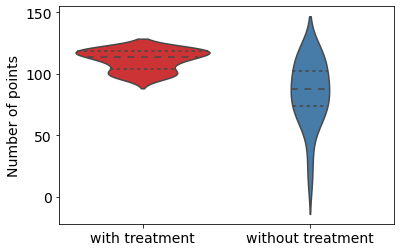

In [288]:
p1 = sns.violinplot(data=df_points, x="treatment", y="points", inner="quart")
p1.set(xlabel=None)
p1.set(ylabel="Number of points")

In [248]:
df_points_with_treatment = df[df.llm_support == True].groupby("experiment_subject")["points"].sum().reset_index()
df_points_wo_treatment = df[df.llm_support == False].groupby("experiment_subject")["points"].sum().reset_index()
df_points = pd.merge(df_points_with_treatment, df_points_wo_treatment, on="experiment_subject", how="outer")
df_points.rename(columns={"points_x": "with treatment", "points_y": "without treatment"}, inplace=True)
df_points.drop(columns=["experiment_subject"], inplace=True)
df_points.describe()

,with treatment,without treatment
count,24.000000,24.000000
mean,111.583333,84.500000
std,8.208779,26.362028
min,97.000000,14.000000
25%,104.250000,73.500000
50%,113.500000,87.500000
75%,118.500000,102.000000
max,120.000000,119.000000


In [249]:
anderson(df_points["with treatment"])

AndersonResult(statistic=1.2443488934861264, critical_values=array([0.513, 0.584, 0.701, 0.817, 0.972]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [250]:
anderson(df_points["without treatment"])

AndersonResult(statistic=0.4447877817152488, critical_values=array([0.513, 0.584, 0.701, 0.817, 0.972]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [29]:
mannwhitneyu(df_points["with treatment"], df_points["without treatment"])

MannwhitneyuResult(statistic=494.0, pvalue=2.1943369188347926e-05)

In [251]:
compute_improvement_pct(df_points)

('increase', ['without treatment', 'with treatment'], 29.71)

In [325]:
def map_grade(danish_grade):
    grades = [-3, 0, 2, 4, 7, 10, 12]
    numerical_grades = range(7)
    grade_map = dict(zip(grades, numerical_grades))
    return grade_map[danish_grade]


def map_grade_to_str_label(danish_grade):
    grades = [-3, 0, 2, 4, 7, 10, 12]
    grade_labels = ["-3", "00", "02", "4", "7", "10", "12"]
    grade_map = dict(zip(grades, grade_labels))
    return grade_map[danish_grade]

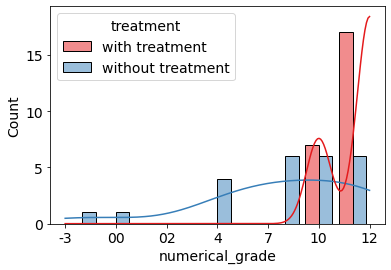

In [326]:
df["grade_label"] = df.grade.apply(map_grade_to_str_label)
df_grades_with_treatment = df[df.llm_support == True].groupby("experiment_subject")["numerical_grade"].first().reset_index()
df_grades_with_treatment["treatment"] = "with treatment"
df_grades_wo_treatment = df[df.llm_support == False].groupby("experiment_subject")["numerical_grade"].first().reset_index()
df_grades_wo_treatment["treatment"] = "without treatment"

#df_grades = pd.merge(df_grades_with_treatment, df_grades_wo_treatment, on="experiment_subject") # , left_index=True, right_index=True)
df_grades = pd.concat((df_grades_with_treatment, df_grades_wo_treatment), axis=0, ignore_index=True)
#df_grades.rename(columns={"numerical_grade_x": "with treatment", "numerical_grade_y": "without treatment"}, inplace=True)
df_grades.drop(columns=["experiment_subject"], inplace=True)
df_grades
p = sns.histplot(data=df_grades, x="numerical_grade", hue="treatment", multiple="dodge", kde=True,  shrink=.8) 
p.set_xticks(range(7), labels=["-3", "00", "02", "4", "7", "10", "12"]) 
plt.savefig("images/grade_comparison.pdf", bbox_inches="tight")

<AxesSubplot:xlabel='grade_label', ylabel='Count'>

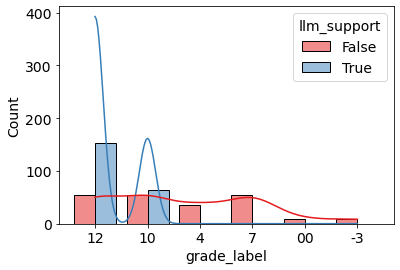

In [327]:
sns.histplot(data=df, x="grade_label", hue="llm_support", multiple="dodge", kde=True,  shrink=.8) 


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


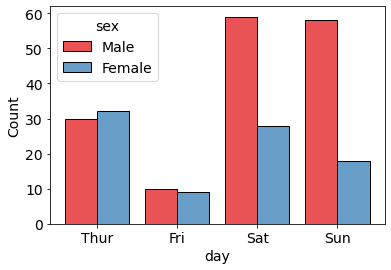

In [319]:
tips = sns.load_dataset("tips")
sns.histplot(data=tips, x="day", hue="sex", multiple="dodge", shrink=.8)
tips

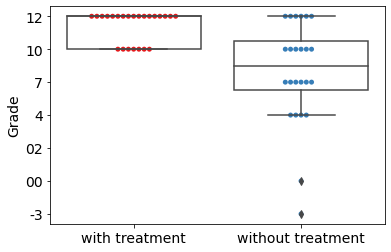

In [292]:
df_grades_with_treatment = df[df.llm_support == True].groupby("experiment_subject")["grade"].first().reset_index()
df_grades_with_treatment["treatment"] = "with treatment"
df_grades_wo_treatment = df[df.llm_support == False].groupby("experiment_subject")["grade"].first().reset_index()
df_grades_wo_treatment["treatment"] = "without treatment"

df_grades = pd.concat((df_grades_with_treatment, df_grades_wo_treatment), axis=0, ignore_index=True)
df_grades.drop(columns=["experiment_subject"], inplace=True)

df_grades["numerical_grade"] = df_grades.grade.apply(map_grade)
p1 = sns.boxplot(data=df_grades, x="treatment", y="numerical_grade", boxprops={"facecolor": "None"})
p2 = sns.swarmplot(data=df_grades, x="treatment", y="numerical_grade", zorder=.5)
p1.set(xlabel=None)
p1.set(ylabel="Grade")
p1.set_yticks(range(7), labels=["-3", "00", "02", "4", "7", "10", "12"]) 

In [252]:
df_grades.describe()

,with treatment,without treatment
count,24.000000,24.000000
mean,11.416667,7.791667
std,0.928611,4.032252
min,10.000000,-3.000000
25%,10.000000,6.250000
50%,12.000000,8.500000
75%,12.000000,10.500000
max,12.000000,12.000000


In [253]:
anderson(df_grades["with treatment"])

AndersonResult(statistic=5.1648645777396, critical_values=array([0.513, 0.584, 0.701, 0.817, 0.972]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [254]:
anderson(df_grades["without treatment"])

AndersonResult(statistic=1.0218881095046655, critical_values=array([0.513, 0.584, 0.701, 0.817, 0.972]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [255]:
mannwhitneyu(df_grades["with treatment"], df_grades["without treatment"])

MannwhitneyuResult(statistic=462.0, pvalue=0.00012301770813022747)

In [256]:
compute_improvement_pct(df_grades)

('increase', ['without treatment', 'with treatment'], 41.18)

### RQ4: How does the way students prompt a local LLM affect their grade?

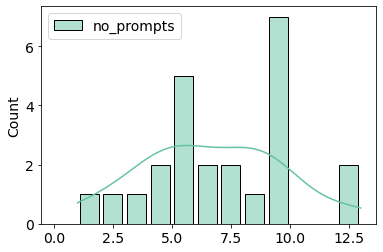

In [55]:
df_prompts = df[df.llm_support == True].groupby("experiment_subject")["no_prompts"].sum().reset_index()
df_prompts.drop(columns=["experiment_subject"], inplace=True)

sns.histplot(df_prompts, color='blue', multiple="dodge", kde=True, 
             binrange=(0, df_prompts.no_prompts.max()), binwidth=1, shrink=.8)
plt.savefig("images/prompt_histogram.pdf", bbox_inches="tight")

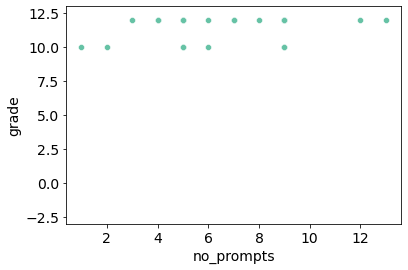

In [36]:
df_prompts = df[df.llm_support == True].groupby("experiment_subject")["no_prompts"].sum().reset_index()
df_prompts_grades = pd.merge(df_prompts, df_grades_with_treatment, on="experiment_subject")
df_prompts_grades.drop(columns=["experiment_subject"], inplace=True)
sns.scatterplot(data=df_prompts_grades, x="no_prompts", y="grade")
plt.ylim(-3, 13)
plt.savefig("images/grade_prompt_comparison.pdf", bbox_inches="tight")

In [37]:
spearmanr(df_prompts_grades.no_prompts, df_prompts_grades.grade)

SpearmanrResult(correlation=0.2560509901961664, pvalue=0.2271685140863654)